In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/traffic-prediction-dataset/Traffic.csv


In [2]:
df = pd.read_csv('/kaggle/input/traffic-prediction-dataset/Traffic.csv')
df

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,12:00:00 AM,10,Tuesday,31,0,4,4,39,low
1,12:15:00 AM,10,Tuesday,49,0,3,3,55,low
2,12:30:00 AM,10,Tuesday,46,0,3,6,55,low
3,12:45:00 AM,10,Tuesday,51,0,2,5,58,low
4,1:00:00 AM,10,Tuesday,57,6,15,16,94,normal
...,...,...,...,...,...,...,...,...,...
2971,10:45:00 PM,9,Thursday,16,3,1,36,56,normal
2972,11:00:00 PM,9,Thursday,11,0,1,30,42,normal
2973,11:15:00 PM,9,Thursday,15,4,1,25,45,normal
2974,11:30:00 PM,9,Thursday,16,5,0,27,48,normal


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2976 entries, 0 to 2975
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Time               2976 non-null   object
 1   Date               2976 non-null   int64 
 2   Day of the week    2976 non-null   object
 3   CarCount           2976 non-null   int64 
 4   BikeCount          2976 non-null   int64 
 5   BusCount           2976 non-null   int64 
 6   TruckCount         2976 non-null   int64 
 7   Total              2976 non-null   int64 
 8   Traffic Situation  2976 non-null   object
dtypes: int64(6), object(3)
memory usage: 209.4+ KB


In [4]:
def p_null_data(data):
    null_data = data.isna().sum()
    null_percent = data.isna().sum() / len(data)
    null_percent = null_percent.apply(lambda x: f'{x:.1%}')
    print("Total duplicated data count: ", data.duplicated().sum())
    result = pd.concat([null_data, null_percent], axis=1)
    result.columns = ['Null Data Count', 'Null Percentage']
    return result
p_null_data(df)

Total duplicated data count:  0


,Null Data Count,Null Percentage
Time,0,0.0%
Date,0,0.0%
Day of the week,0,0.0%
CarCount,0,0.0%
BikeCount,0,0.0%
BusCount,0,0.0%
TruckCount,0,0.0%
Total,0,0.0%
Traffic Situation,0,0.0%


In [5]:
def hstplt(data, features):
    plt.figure(figsize=(9, 3))
    sns.histplot(data, x=features, hue='Traffic Situation', kde=True)
    plt.xlabel(features)
    plt.ylabel("Traffic Situation")
    plt.title(f"Histplot between {features} and Traffic Situation")
    plt.show()

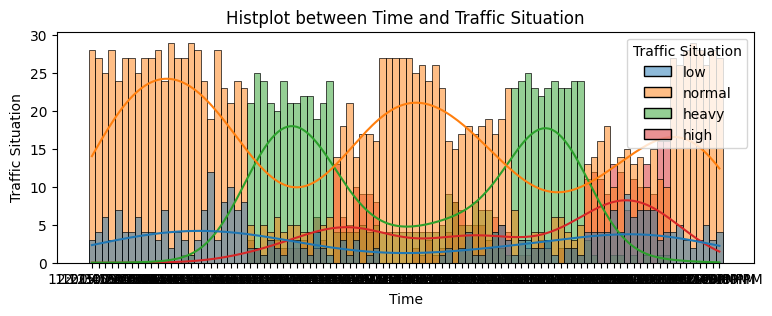

------------------------------------------------------------------------------------------


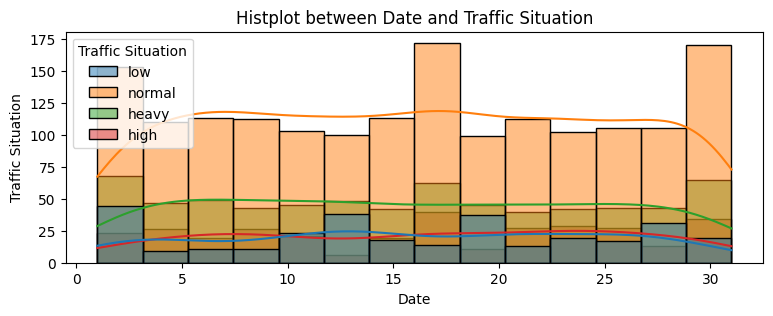

------------------------------------------------------------------------------------------


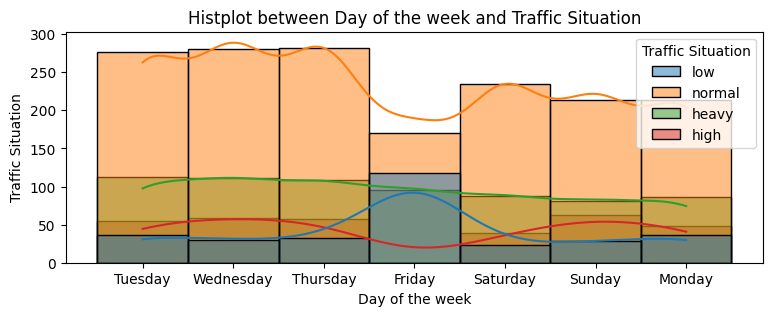

------------------------------------------------------------------------------------------


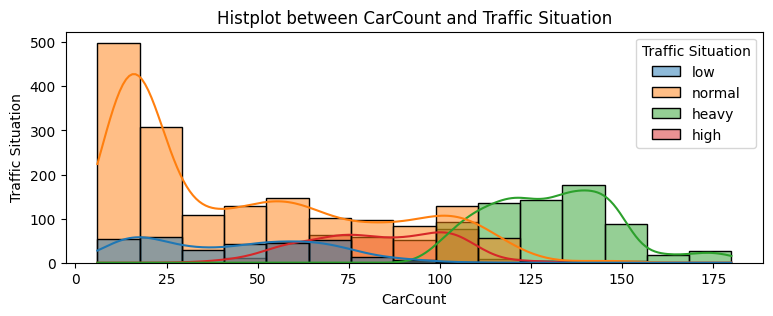

------------------------------------------------------------------------------------------


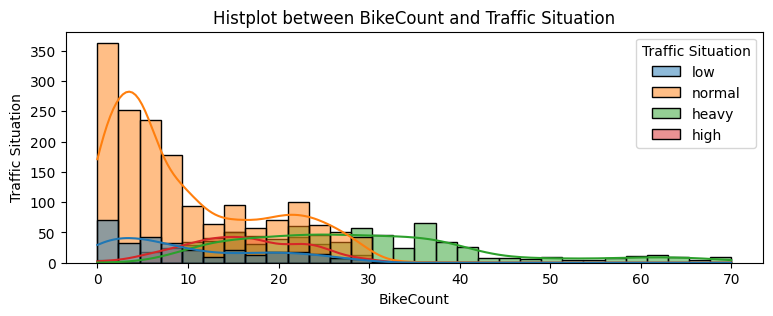

------------------------------------------------------------------------------------------


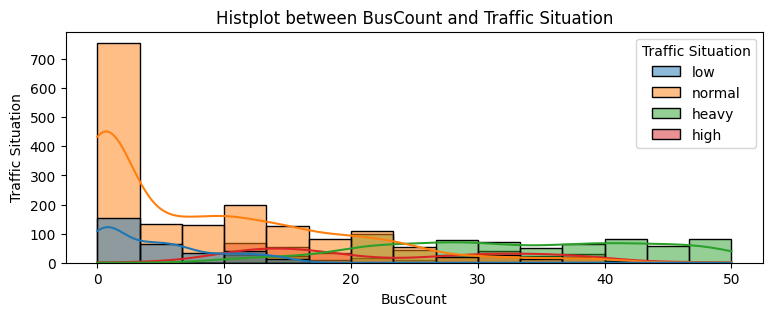

------------------------------------------------------------------------------------------


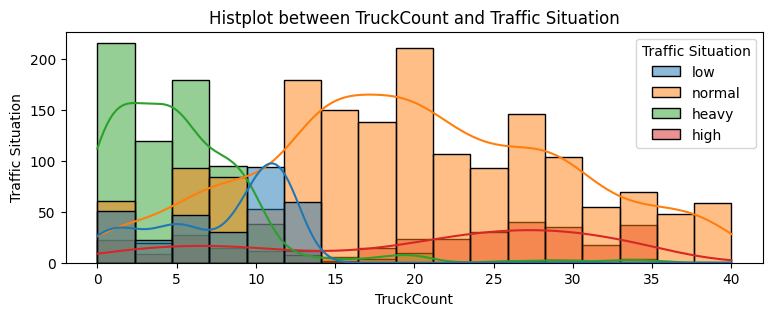

------------------------------------------------------------------------------------------


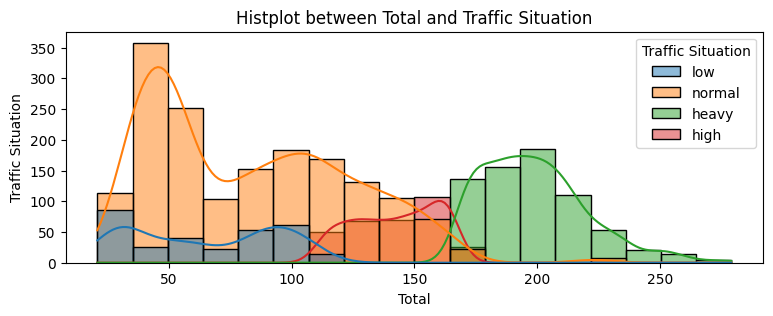

------------------------------------------------------------------------------------------


In [6]:
for i in df:
    if i == 'Traffic Situation':
        continue
    hstplt(df, i)
    print('---' * 30)

In [7]:
df_selected_columns = df.select_dtypes(include=['int64'])

In [8]:
from collections import Counter

In [9]:
def detect_outliers(data, features):
    outlier_indices = []
    for i in features:
        Q1 = np.percentile(data[i], 25)
        Q3 = np.percentile(data[i], 75)
        
        IQR = Q3 - Q1
        
        outlier_step = IQR * 1.5
        outlier_list_column = data[(data[i] < Q1 - outlier_step) | (data[i] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_column)
    
    outlier_indices = Counter(outlier_indices)
    multiple_indices = list(i for i, v in outlier_indices.items() if v > 2)
    return  multiple_indices

In [10]:
detect_outliers(df, df_selected_columns)

[]

In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [12]:
df.drop('Time', axis=1, inplace=True)

In [13]:
le = LabelEncoder()
df['Day_of_the_week'] = le.fit_transform(df['Day of the week'])
df['Traffic_Situation'] = le.fit_transform(df['Traffic Situation'])
df.drop(['Day of the week', 'Traffic Situation'], inplace=True, axis=1)

In [14]:
X = df.drop('Traffic_Situation', axis=1)
y = df['Traffic_Situation']

In [15]:
df

,Date,CarCount,BikeCount,BusCount,TruckCount,Total,Day_of_the_week,Traffic_Situation
0,10,31,0,4,4,39,5,2
1,10,49,0,3,3,55,5,2
2,10,46,0,3,6,55,5,2
3,10,51,0,2,5,58,5,2
4,10,57,6,15,16,94,5,3
...,...,...,...,...,...,...,...,...
2971,9,16,3,1,36,56,4,3
2972,9,11,0,1,30,42,4,3
2973,9,15,4,1,25,45,4,3
2974,9,16,5,0,27,48,4,3


In [16]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [17]:
X

array([[-0.67082039, -0.82229744, -1.16130181, ..., -1.06818318,
        -1.24987989,  0.9001866 ],
       [-0.67082039, -0.42965289, -1.16130181, ..., -1.16250455,
        -0.9840131 ,  0.9001866 ],
       [-0.67082039, -0.49509365, -1.16130181, ..., -0.87954044,
        -0.9840131 ,  0.9001866 ],
       ...,
       [-0.78262379, -1.17131482, -0.8499053 , ...,  0.91256559,
        -1.15017985,  0.40186902],
       [-0.78262379, -1.14950124, -0.77205617, ...,  1.10120833,
        -1.10032982,  0.40186902],
       [-0.78262379, -1.19312841, -0.92775443, ..., -0.03064811,
        -1.34957994,  0.40186902]])

In [18]:
X_train, X_test, y_encoded_train, y_encoded_test = train_test_split(X, y, train_size=0.3, random_state=42)

In [19]:
seed = 42
models = [
    RandomForestClassifier(random_state=seed),
    GradientBoostingClassifier(random_state=seed),
    LogisticRegression(random_state=seed),
    DecisionTreeClassifier(random_state=seed),
    KNeighborsClassifier(),
    XGBClassifier(),
    AdaBoostClassifier(random_state=seed),
    CatBoostClassifier(verbose=False)
]
rf_param = {
    'max_features': [1, 3, 10],
    'min_samples_leaf': [1, 3, 10],
    'bootstrap': [False],
    'n_estimators': [100, 300],
    'criterion': ['gini']
}
gradient_param = {
    'loss': ['log_loss'],
    'n_estimators': [100, 200, 300],

}
logreg_param = {
    'C': np.linspace(-3, 3, 7),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'max_iter': [100, 300]
}
dt_param = {
    'criterion': ['gini','entropy','log_loss'],
    'max_depth': np.arange(1, 100, 20),
    "min_samples_split": range(10, 500, 20)

}
knn_param = {
    'n_neighbors': np.arange(1, 20, 2),
    'metric': ['euclidean', 'manhattan'],
    'n_jobs': np.arange(1, 100, 20),

}
xgb_param = {
    'max_depth': np.arange(1, 100, 20),
}
ada_param = {
    'algorithm': ['SAMME', 'SAMME.R'],
    'n_estimators': [100, 200 ,300],
}
cat_param = {
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.1, 0.2],
}
classifier_param = [
    rf_param,
    gradient_param,
    logreg_param,
    dt_param,
    knn_param,
    xgb_param,
    ada_param,
    cat_param
]
results = []
clf_best_score = []
clf_best_estimators = []
for i in range(len(models)):
    clf = GridSearchCV(models[i], classifier_param[i], scoring='accuracy', verbose=1,
                       cv=10, n_jobs=-1)
    clf.fit(X_train, y_encoded_train)
    clf_best_score.append(clf.best_score_)
    clf_best_estimators.append(clf.best_estimator_)
    results.append({"Algorithm": models[i],"Best Estimators": clf_best_estimators[i], "Accuracy": clf_best_score[i]})
results = pd.DataFrame(results)
results.sort_values(by='Accuracy', ascending=True)
results

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 28 candidates, totalling 280 fits
Fitting 10 folds for each of 375 candidates, totalling 3750 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Fitting 10 folds for each of 9 candidates, totalling 90 fits


,Algorithm,Best Estimators,Accuracy
0,RandomForestClassifier(random_state=42),"(DecisionTreeClassifier(max_features=3, random...",0.991011
1,GradientBoostingClassifier(random_state=42),([DecisionTreeRegressor(criterion='friedman_ms...,0.993258
2,LogisticRegression(random_state=42),"LogisticRegression(C=3.0, penalty='l1', random...",0.818427
3,DecisionTreeClassifier(random_state=42),"DecisionTreeClassifier(criterion='entropy', ma...",0.994382
4,KNeighborsClassifier(),"KNeighborsClassifier(metric='manhattan', n_job...",0.886754
5,"XGBClassifier(base_score=None, booster=None, c...","XGBClassifier(base_score=None, booster=None, c...",0.993258
6,AdaBoostClassifier(random_state=42),"(DecisionTreeClassifier(max_depth=1, random_st...",0.820649
7,<catboost.core.CatBoostClassifier object at 0x...,<catboost.core.CatBoostClassifier object at 0x...,0.996629


In [20]:
votingC = VotingClassifier(estimators=[('XGB', clf_best_estimators[5]),
                                       ('DT', clf_best_estimators[3]),
                                       ('GR', clf_best_estimators[1]),
                                       ('RF', clf_best_estimators[0]),
                                       ('cat', clf_best_estimators[7])],
                           voting='soft', n_jobs=-1, verbose=2)
votingC.fit(X_train, y_encoded_train)
y_pred = votingC.predict(X_test)
print(accuracy_score(y_encoded_test, y_pred))

0.996641074856046
